Index(['OBJECTID', 'ChargeId', 'IncidentNumber', 'ReportNumber',
       'FireArmInvolved', 'ReportDate', 'OccurredFromDate', 'OccurredToDate',
       'Day_of_the_week', 'Day_Number', 'Part', 'Crime_Against',
       'NibrsUcrCode', 'NIBRS_Offense', 'StreetAddress', 'Longitude',
       'Latitude', 'IsBiasMotivationInvolved', 'event_watch', 'Zone',
       'Zone_int', 'LocationType', 'Beat', 'NhoodName', 'DISTRICT', 'NPU',
       'GlobalID', 'x', 'y', 'OffenseGroup', 'TimeCategory',
       'Offense_Category', 'Month', 'PatrolType', 'NhoodEncoded',
       'TimeCategoryEncoded', 'OffenseCategoryEncoded'],
      dtype='object')


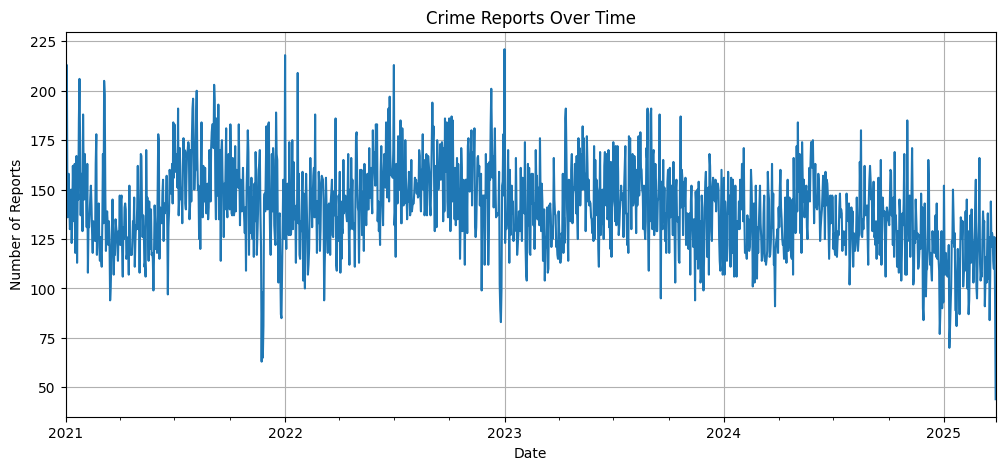

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Reports   No. Observations:                 1548
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6746.218
Date:                Sun, 13 Apr 2025   AIC                          13498.437
Time:                        23:06:26   BIC                          13514.469
Sample:                    01-01-2021   HQIC                         13504.400
                         - 03-28-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2179      0.025      8.760      0.000       0.169       0.267
ma.L1         -0.9473      0.009   -107.940      0.000      -0.965      -0.930
sigma2       358.7394     11.426     31.395      0.0

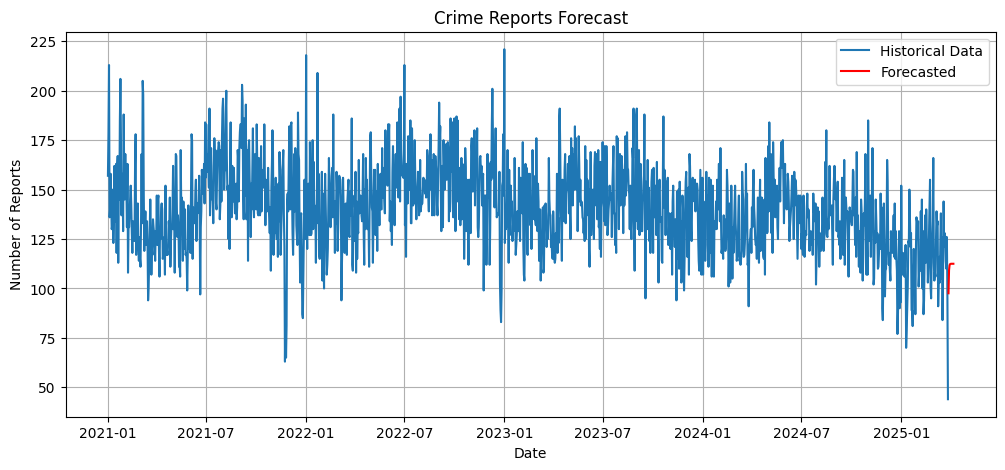

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


df = pd.read_csv('/content/updated_patrol_types.csv')
print(df.columns)


df["OccurredFromDate"] = pd.to_datetime(df["OccurredFromDate"])
df_aggregated = df.groupby(df['OccurredFromDate'].dt.date).size()

df_aggregated = pd.DataFrame(df_aggregated)
df_aggregated.columns = ['Reports']

df_aggregated.index = pd.to_datetime(df_aggregated.index)

plt.figure(figsize=(12, 5))
df_aggregated['Reports'].plot()
plt.title("Crime Reports Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reports")
plt.grid()
plt.show()

model = ARIMA(df_aggregated['Reports'], order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=10)

plt.figure(figsize=(12, 5))
plt.plot(df_aggregated.index, df_aggregated['Reports'], label='Historical Data')
plt.plot(pd.date_range(df_aggregated.index[-1], periods=11, freq='D')[1:], forecast, label='Forecasted', color='red')
plt.title("Crime Reports Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Reports")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

df = pd.read_csv('xgb_compatible_crime_data.csv', low_memory=False)

crime_features = ['TimeCategoryEncoded', 'NhoodEncoded', 'Day_Number', 'Month']
crime_target = 'OffenseCategoryEncoded'

X_crime = df[crime_features]
y_crime = df[crime_target]

X_train_crime, X_test_crime, y_train_crime, y_test_crime = train_test_split(X_crime, y_crime, test_size=0.10, random_state=62)

crime_model = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.2,
    objective='multi:softmax',
    num_class=len(y_crime.unique()),
    random_state=62,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

crime_model.fit(X_train_crime, y_train_crime)

print("X train crime")
print(len(X_train_crime))
accuracy = crime_model.score(X_test_crime, y_test_crime)
print(f"accuracy: {accuracy:.2f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:54:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


X train crime
195596
accuracy: 0.55


In [ ]:
def predict_crime_and_patrol(time_category_encoded, month, neighborhood_encoded, day_of_week_encoded):
    input_data = pd.DataFrame({
        'TimeCategoryEncoded': [time_category_encoded],
        'NhoodEncoded': [neighborhood_encoded],
        'Day_Number': [day_of_week_encoded],
        'Month': [month]
    })

    print(len(input_data))
    print(input_data)

    crime_prediction_code = crime_model.predict(input_data)

    print(crime_prediction_code)
    print(f"Raw prediction code: {crime_prediction_code[0]}, Type: {type(crime_prediction_code[0])}")
    return crime_prediction_code[0]

time_category_encoded = 2
month = 1
neighborhood_encoded = 121
day_of_week_encoded = 1

crime = predict_crime_and_patrol(time_category_encoded, month, neighborhood_encoded, day_of_week_encoded)
print(f"Predicted Crime: {crime}")
predicted_crime_label = le.inverse_transform([crime])
print(f"Predicted Crime Label: {predicted_crime_label}")

1
   TimeCategoryEncoded  NhoodEncoded  Day_Number  Month
0                    2           121           1      1
[0]
Raw prediction code: 0, Type: <class 'numpy.int32'>
Predicted Crime: 0
Predicted Crime Label: [0]


In [ ]:
# print(neighborhood_to_int)

In [ ]:
print(y_crime.value_counts(normalize=True))  # To see if a few classes dominate


OffenseCategoryEncoded
0    0.553226
3    0.250984
1    0.114251
2    0.081540
Name: proportion, dtype: float64


In [ ]:
# Per month Per neighbourhood - predict crime number

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

models = {}
metrics = {}

int_to_neighborhood = {v: k for k, v in neighborhood_to_int.items()}

for nhood_id in df['NhoodEncoded'].unique():
    df_nhood = df[df['NhoodEncoded'] == nhood_id].copy()

    df_grouped = df_nhood.groupby(df_nhood['OccurredFromDate'].dt.date).size().reset_index(name='CrimeCount')
    df_grouped.rename(columns={'OccurredFromDate': 'Date'}, inplace=True)
    df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])

    if len(df_grouped) < 100:
        continue

    df_grouped['DayOfWeek'] = df_grouped['Date'].dt.dayofweek
    df_grouped['Month'] = df_grouped['Date'].dt.month
    df_grouped = df_grouped.sort_values(by='Date')
    df_grouped['PrevCrime'] = df_grouped['CrimeCount'].shift(1)
    df_grouped = df_grouped.dropna()

    X = df_grouped[['DayOfWeek', 'Month', 'PrevCrime']]
    y = df_grouped['CrimeCount']
    months = df_grouped['Month']

    X_train, X_test, y_train, y_test, months_train, months_test = train_test_split(
        X, y, months, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Overall metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metrics[nhood_id] = {'MAE': mae, 'R2': r2}
    models[nhood_id] = model

    print(f"\n Neighborhood {nhood_id} | {int_to_neighborhood[nhood_id]} — MAE: {mae:.2f}, R²: {r2:.2f}")

    # Monthly breakdown
    df_eval = pd.DataFrame({'Month': months_test, 'Actual': y_test, 'Predicted': y_pred})
    for m in sorted(df_eval['Month'].unique()):
        sub = df_eval[df_eval['Month'] == m]
        m_mae = mean_absolute_error(sub['Actual'], sub['Predicted'])
        m_r2 = r2_score(sub['Actual'], sub['Predicted'])
        print(f"   📆 Month {m}: MAE = {m_mae:.2f}, R² = {m_r2:.2f}")



🏙️ Neighborhood 110 | Lenox — MAE: 1.09, R²: -0.31
   📆 Month 1: MAE = 1.17, R² = -0.92
   📆 Month 2: MAE = 1.29, R² = -0.36
   📆 Month 3: MAE = 1.16, R² = -0.25
   📆 Month 4: MAE = 0.87, R² = -1.07
   📆 Month 5: MAE = 0.98, R² = -0.07
   📆 Month 6: MAE = 1.20, R² = -0.02
   📆 Month 7: MAE = 1.04, R² = -0.45
   📆 Month 8: MAE = 1.01, R² = -1.37
   📆 Month 9: MAE = 1.00, R² = -0.19
   📆 Month 10: MAE = 1.26, R² = -0.53
   📆 Month 11: MAE = 0.79, R² = -0.28
   📆 Month 12: MAE = 1.32, R² = -0.56

🏙️ Neighborhood 70 | Edgewood — MAE: 0.98, R²: -0.19
   📆 Month 1: MAE = 0.94, R² = -0.22
   📆 Month 2: MAE = 0.83, R² = 0.09
   📆 Month 3: MAE = 0.78, R² = 0.00
   📆 Month 4: MAE = 0.76, R² = 0.25
   📆 Month 5: MAE = 1.06, R² = 0.07
   📆 Month 6: MAE = 0.94, R² = -1.27
   📆 Month 7: MAE = 0.90, R² = -0.87
   📆 Month 8: MAE = 1.08, R² = -1.64
   📆 Month 9: MAE = 1.11, R² = -0.05
   📆 Month 10: MAE = 1.17, R² = -1.35
   📆 Month 11: MAE = 1.19, R² = -0.24
   📆 Month 12: MAE = 1.18, R² = -0.44

🏙️ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 61 | Cross Creek — MAE: 0.36, R²: -0.69
   📆 Month 1: MAE = 0.86, R² = -1.93
   📆 Month 2: MAE = 0.09, R² = 0.00
   📆 Month 3: MAE = 0.65, R² = -0.37
   📆 Month 4: MAE = 0.26, R² = -0.36
   📆 Month 5: MAE = 0.22, R² = 0.00
   📆 Month 6: MAE = 1.39, R² = -7.48
   📆 Month 7: MAE = 0.20, R² = 0.00
   📆 Month 8: MAE = 0.37, R² = -0.44
   📆 Month 9: MAE = 0.42, R² = 0.13
   📆 Month 10: MAE = 0.23, R² = 0.00
   📆 Month 12: MAE = 0.18, R² = -0.17

🏙️ Neighborhood 106 | Lakewood — MAE: 0.35, R²: -0.39
   📆 Month 1: MAE = 0.36, R² = 0.00
   📆 Month 2: MAE = 0.68, R² = -0.64
   📆 Month 3: MAE = 0.26, R² = 0.00
   📆 Month 4: MAE = 0.43, R² = 0.00
   📆 Month 5: MAE = 0.47, R² = -0.98
   📆 Month 6: MAE = 0.24, R² = 0.00
   📆 Month 7: MAE = 0.13, R² = -0.09
   📆 Month 8: MAE = 0.27, R² = 0.00
   📆 Month 9: MAE = 0.41, R² = -1.04
   📆 Month 10: MAE = 0.71, R² = -0.28
   📆 Month 11: MAE = 0.10, R² = 0.00
   📆 Month 12: MAE = 0.01, R² = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 95 | Home Park — MAE: 1.83, R²: -0.38
   📆 Month 1: MAE = 1.81, R² = -0.77
   📆 Month 2: MAE = 2.53, R² = -0.61
   📆 Month 3: MAE = 1.53, R² = -0.27
   📆 Month 4: MAE = 1.47, R² = -0.65
   📆 Month 5: MAE = 1.50, R² = -0.19
   📆 Month 6: MAE = 1.38, R² = -0.78
   📆 Month 7: MAE = 1.31, R² = 0.04
   📆 Month 8: MAE = 1.90, R² = -0.65
   📆 Month 9: MAE = 2.27, R² = -0.40
   📆 Month 10: MAE = 1.90, R² = -0.12
   📆 Month 11: MAE = 2.21, R² = -0.78
   📆 Month 12: MAE = 1.98, R² = -0.17

🏙️ Neighborhood 119 | Mechanicsville — MAE: 1.71, R²: -0.30
   📆 Month 1: MAE = 1.32, R² = -2.04
   📆 Month 2: MAE = 1.53, R² = -0.16
   📆 Month 3: MAE = 1.53, R² = -0.65
   📆 Month 4: MAE = 1.67, R² = 0.15
   📆 Month 5: MAE = 1.43, R² = -0.10
   📆 Month 6: MAE = 1.76, R² = -0.09
   📆 Month 7: MAE = 1.85, R² = -0.41
   📆 Month 8: MAE = 1.85, R² = -0.45
   📆 Month 9: MAE = 2.18, R² = -0.34
   📆 Month 10: MAE = 1.57, R² = -1.04
   📆 Month 11: MAE = 1.85, R² = -1.10
   📆 Month 12: MAE = 2.15, R² 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 107 | Lakewood Heights — MAE: 1.29, R²: -0.29
   📆 Month 1: MAE = 1.29, R² = -0.17
   📆 Month 2: MAE = 1.09, R² = -0.18
   📆 Month 3: MAE = 1.62, R² = -0.21
   📆 Month 4: MAE = 1.19, R² = -0.18
   📆 Month 5: MAE = 1.27, R² = 0.16
   📆 Month 6: MAE = 1.30, R² = -0.41
   📆 Month 7: MAE = 1.14, R² = -0.64
   📆 Month 8: MAE = 1.93, R² = -1.54
   📆 Month 9: MAE = 0.98, R² = -0.28
   📆 Month 10: MAE = 1.56, R² = -1.00
   📆 Month 11: MAE = 0.83, R² = -0.34
   📆 Month 12: MAE = 1.16, R² = -0.20

🏙️ Neighborhood 151 | Poncey-Highland — MAE: 0.72, R²: -0.16
   📆 Month 1: MAE = 0.96, R² = -0.36
   📆 Month 2: MAE = 0.65, R² = -0.27
   📆 Month 3: MAE = 0.82, R² = 0.02
   📆 Month 4: MAE = 0.99, R² = -0.28
   📆 Month 5: MAE = 0.49, R² = -0.35
   📆 Month 6: MAE = 0.44, R² = -0.89
   📆 Month 7: MAE = 0.80, R² = -0.16
   📆 Month 8: MAE = 0.64, R² = 0.09
   📆 Month 9: MAE = 0.76, R² = -0.43
   📆 Month 10: MAE = 0.80, R² = -0.68
   📆 Month 11: MAE = 0.41, R² = 0.02
   📆 Month 12: MAE = 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 42 | Capitol View — MAE: 0.55, R²: -0.14
   📆 Month 1: MAE = 0.54, R² = -0.33
   📆 Month 2: MAE = 0.58, R² = -0.17
   📆 Month 3: MAE = 0.61, R² = -0.25
   📆 Month 4: MAE = 0.80, R² = -0.08
   📆 Month 5: MAE = 0.40, R² = -0.23
   📆 Month 6: MAE = 0.46, R² = -0.79
   📆 Month 7: MAE = 0.59, R² = -0.61
   📆 Month 8: MAE = 0.55, R² = 0.08
   📆 Month 9: MAE = 0.62, R² = 0.08
   📆 Month 10: MAE = 0.58, R² = -0.59
   📆 Month 11: MAE = 0.49, R² = 0.27
   📆 Month 12: MAE = 0.28, R² = 0.00

🏙️ Neighborhood 177 | Underwood Hills — MAE: 0.88, R²: -0.33
   📆 Month 1: MAE = 1.02, R² = -1.05
   📆 Month 2: MAE = 0.71, R² = 0.20
   📆 Month 3: MAE = 0.76, R² = -0.24
   📆 Month 4: MAE = 0.89, R² = -0.22
   📆 Month 5: MAE = 0.95, R² = -0.36
   📆 Month 6: MAE = 0.76, R² = -0.39
   📆 Month 7: MAE = 0.65, R² = 0.02
   📆 Month 8: MAE = 0.86, R² = -0.29
   📆 Month 9: MAE = 0.74, R² = -1.09
   📆 Month 10: MAE = 0.92, R² = -0.55
   📆 Month 11: MAE = 1.39, R² = -0.91
   📆 Month 12: MAE = 0.92, R² 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 181 | Washington Park — MAE: 0.51, R²: -0.12
   📆 Month 1: MAE = 0.54, R² = -0.00
   📆 Month 2: MAE = 0.51, R² = -0.11
   📆 Month 3: MAE = 0.48, R² = -0.62
   📆 Month 4: MAE = 0.41, R² = -0.81
   📆 Month 5: MAE = 0.54, R² = -0.21
   📆 Month 6: MAE = 0.40, R² = 0.54
   📆 Month 7: MAE = 0.48, R² = -1.05
   📆 Month 8: MAE = 0.54, R² = -0.34
   📆 Month 9: MAE = 0.34, R² = -0.92
   📆 Month 10: MAE = 0.81, R² = -0.89
   📆 Month 11: MAE = 0.55, R² = -2.90
   📆 Month 12: MAE = 0.44, R² = 0.47

🏙️ Neighborhood 168 | Summerhill — MAE: 0.81, R²: -0.36
   📆 Month 1: MAE = 0.76, R² = -0.46
   📆 Month 2: MAE = 1.05, R² = -0.20
   📆 Month 3: MAE = 0.71, R² = -1.19
   📆 Month 4: MAE = 1.09, R² = -0.46
   📆 Month 5: MAE = 0.77, R² = -0.19
   📆 Month 6: MAE = 1.07, R² = -1.65
   📆 Month 7: MAE = 0.89, R² = -0.55
   📆 Month 8: MAE = 0.40, R² = -0.08
   📆 Month 9: MAE = 0.64, R² = -0.37
   📆 Month 10: MAE = 0.74, R² = -0.18
   📆 Month 11: MAE = 0.87, R² = -0.56
   📆 Month 12: MAE = 0.61, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 23 | Blandtown — MAE: 0.89, R²: -0.60
   📆 Month 1: MAE = 0.80, R² = -1.23
   📆 Month 2: MAE = 0.97, R² = -2.62
   📆 Month 3: MAE = 0.51, R² = -0.89
   📆 Month 4: MAE = 0.91, R² = -0.35
   📆 Month 5: MAE = 0.91, R² = -0.33
   📆 Month 6: MAE = 0.85, R² = -7.68
   📆 Month 7: MAE = 0.52, R² = -0.84
   📆 Month 8: MAE = 1.05, R² = -0.81
   📆 Month 9: MAE = 1.08, R² = -0.33
   📆 Month 10: MAE = 0.61, R² = -0.28
   📆 Month 11: MAE = 1.09, R² = -0.41
   📆 Month 12: MAE = 1.02, R² = -1.42

🏙️ Neighborhood 17 | Bankhead/Bolton — MAE: 0.41, R²: -0.33
   📆 Month 1: MAE = 0.28, R² = 0.00
   📆 Month 2: MAE = 0.29, R² = -0.44
   📆 Month 3: MAE = 0.46, R² = -0.04
   📆 Month 4: MAE = 0.49, R² = -0.61
   📆 Month 5: MAE = 0.42, R² = 0.00
   📆 Month 6: MAE = 0.23, R² = -0.35
   📆 Month 7: MAE = 0.39, R² = -0.38
   📆 Month 8: MAE = 0.24, R² = -0.06
   📆 Month 9: MAE = 0.75, R² = -0.29
   📆 Month 10: MAE = 0.21, R² = 0.00
   📆 Month 11: MAE = 1.32, R² = -7.81
   📆 Month 12: MAE = 0.51, R² =

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 157 | Riverside — MAE: 0.42, R²: -0.45
   📆 Month 1: MAE = 0.32, R² = -0.49
   📆 Month 2: MAE = 0.46, R² = 0.17
   📆 Month 3: MAE = 0.63, R² = 0.00
   📆 Month 4: MAE = 0.59, R² = 0.00
   📆 Month 5: MAE = 0.34, R² = -0.20
   📆 Month 6: MAE = 0.30, R² = 0.18
   📆 Month 7: MAE = 0.18, R² = -0.23
   📆 Month 8: MAE = 0.43, R² = -0.43
   📆 Month 9: MAE = 0.33, R² = 0.00
   📆 Month 10: MAE = 0.32, R² = -0.45
   📆 Month 11: MAE = 0.78, R² = -0.13
   📆 Month 12: MAE = 0.34, R² = 0.00

🏙️ Neighborhood 195 | Wildwood (NPU-C) — MAE: 0.63, R²: -0.22
   📆 Month 1: MAE = 0.51, R² = -0.23
   📆 Month 2: MAE = 0.52, R² = 0.10
   📆 Month 3: MAE = 0.87, R² = -0.06
   📆 Month 4: MAE = 0.63, R² = -0.95
   📆 Month 5: MAE = 0.40, R² = -0.06
   📆 Month 6: MAE = 0.48, R² = -1.89
   📆 Month 7: MAE = 0.74, R² = -4.51
   📆 Month 8: MAE = 0.91, R² = -0.34
   📆 Month 9: MAE = 0.43, R² = 0.21
   📆 Month 10: MAE = 0.62, R² = -0.10
   📆 Month 11: MAE = 0.52, R² = -1.66
   📆 Month 12: MAE = 0.99, R² = -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde


🏙️ Neighborhood 188 | Westhaven — MAE: 0.15, R²: -1.27
   📆 Month 1: MAE = 0.30, R² = 0.00
   📆 Month 2: MAE = 0.13, R² = nan
   📆 Month 3: MAE = 0.02, R² = nan
   📆 Month 4: MAE = 0.00, R² = nan
   📆 Month 5: MAE = 0.00, R² = nan
   📆 Month 6: MAE = 0.39, R² = 0.00
   📆 Month 7: MAE = 0.40, R² = nan
   📆 Month 8: MAE = 0.19, R² = 0.49
   📆 Month 9: MAE = 0.14, R² = 0.00
   📆 Month 10: MAE = 0.02, R² = 0.00
   📆 Month 11: MAE = 0.00, R² = 1.00
   📆 Month 12: MAE = 0.00, R² = 1.00

🏙️ Neighborhood 5 | Ansley Park — MAE: 0.33, R²: -1.15
   📆 Month 1: MAE = 0.43, R² = -0.58
   📆 Month 2: MAE = 0.48, R² = 0.00
   📆 Month 3: MAE = 0.00, R² = nan
   📆 Month 4: MAE = 0.17, R² = 0.00
   📆 Month 5: MAE = 0.32, R² = 0.00
   📆 Month 6: MAE = 0.44, R² = 0.00
   📆 Month 7: MAE = 0.29, R² = -0.21
   📆 Month 8: MAE = 0.02, R² = 0.00
   📆 Month 9: MAE = 0.30, R² = -0.17
   📆 Month 10: MAE = 0.02, R² = 0.00
   📆 Month 11: MAE = 0.40, R² = -0.18
   📆 Month 12: MAE = 0.72, R² = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 134 | Ormewood Park — MAE: 0.55, R²: -0.21
   📆 Month 1: MAE = 0.66, R² = -0.28
   📆 Month 2: MAE = 0.77, R² = -0.24
   📆 Month 3: MAE = 0.52, R² = -0.34
   📆 Month 4: MAE = 0.36, R² = -0.17
   📆 Month 5: MAE = 0.48, R² = -0.56
   📆 Month 6: MAE = 0.46, R² = -0.48
   📆 Month 7: MAE = 0.44, R² = -0.13
   📆 Month 8: MAE = 0.42, R² = -0.22
   📆 Month 9: MAE = 0.51, R² = -0.30
   📆 Month 10: MAE = 0.71, R² = -0.72
   📆 Month 11: MAE = 0.65, R² = -0.20
   📆 Month 12: MAE = 0.52, R² = -0.39

🏙️ Neighborhood 78 | Fort Valley — MAE: 0.42, R²: -0.52
   📆 Month 1: MAE = 0.50, R² = -1.00
   📆 Month 2: MAE = 0.42, R² = -0.25
   📆 Month 3: MAE = 0.00, R² = 1.00
   📆 Month 4: MAE = 1.02, R² = 0.00
   📆 Month 5: MAE = 0.45, R² = -0.37
   📆 Month 6: MAE = 0.16, R² = 0.00
   📆 Month 7: MAE = 0.20, R² = 0.00
   📆 Month 8: MAE = 0.51, R² = nan
   📆 Month 10: MAE = 0.45, R² = -0.72
   📆 Month 11: MAE = 0.05, R² = nan
   📆 Month 12: MAE = 0.62, R² = -0.35


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 138 | Peachtree Heights West — MAE: 0.55, R²: -0.23
   📆 Month 1: MAE = 0.54, R² = 0.04
   📆 Month 2: MAE = 0.37, R² = -0.17
   📆 Month 3: MAE = 0.55, R² = -0.77
   📆 Month 4: MAE = 0.59, R² = 0.11
   📆 Month 5: MAE = 0.68, R² = -0.19
   📆 Month 6: MAE = 0.35, R² = -0.21
   📆 Month 7: MAE = 0.76, R² = -0.84
   📆 Month 8: MAE = 0.70, R² = -0.23
   📆 Month 9: MAE = 0.42, R² = 0.02
   📆 Month 10: MAE = 0.73, R² = -0.78
   📆 Month 11: MAE = 0.32, R² = 0.12
   📆 Month 12: MAE = 0.61, R² = -2.53

🏙️ Neighborhood 29 | Brookhaven — MAE: 0.15, R²: -1.95
   📆 Month 2: MAE = 0.15, R² = 0.00
   📆 Month 3: MAE = 0.00, R² = 0.00
   📆 Month 4: MAE = 0.00, R² = nan
   📆 Month 5: MAE = 0.24, R² = 0.00
   📆 Month 6: MAE = 0.34, R² = nan
   📆 Month 7: MAE = 0.06, R² = 0.00
   📆 Month 8: MAE = 0.11, R² = 0.00
   📆 Month 9: MAE = 0.02, R² = 0.00
   📆 Month 10: MAE = 0.44, R² = 0.00
   📆 Month 11: MAE = 0.34, R² = -0.46
   📆 Month 12: MAE = 0.02, R² = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 146 | Pine Hills — MAE: 0.85, R²: -0.37
   📆 Month 1: MAE = 0.58, R² = 0.04
   📆 Month 2: MAE = 0.82, R² = -0.11
   📆 Month 3: MAE = 0.92, R² = -0.39
   📆 Month 4: MAE = 0.88, R² = -1.79
   📆 Month 5: MAE = 0.81, R² = -0.18
   📆 Month 6: MAE = 0.74, R² = 0.10
   📆 Month 7: MAE = 0.85, R² = -9.06
   📆 Month 8: MAE = 0.81, R² = -0.47
   📆 Month 9: MAE = 1.16, R² = -0.50
   📆 Month 10: MAE = 1.09, R² = -0.55
   📆 Month 11: MAE = 0.90, R² = -0.67
   📆 Month 12: MAE = 0.86, R² = -1.64

🏙️ Neighborhood 153 | Rebel Valley Forest — MAE: 0.20, R²: -0.31
   📆 Month 1: MAE = 0.18, R² = 0.77
   📆 Month 2: MAE = 0.00, R² = 0.00
   📆 Month 3: MAE = 0.02, R² = 0.00
   📆 Month 4: MAE = 0.20, R² = nan
   📆 Month 5: MAE = 0.27, R² = -0.32
   📆 Month 6: MAE = 0.06, R² = 0.00
   📆 Month 8: MAE = 0.33, R² = 0.00
   📆 Month 9: MAE = 0.01, R² = nan
   📆 Month 10: MAE = 0.21, R² = -0.25
   📆 Month 11: MAE = 0.39, R² = 0.00
   📆 Month 12: MAE = 0.11, R² = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 185 | West Lake — MAE: 0.37, R²: -0.57
   📆 Month 1: MAE = 0.12, R² = 0.00
   📆 Month 2: MAE = 0.62, R² = -2.54
   📆 Month 3: MAE = 0.31, R² = 0.00
   📆 Month 4: MAE = 0.35, R² = 0.10
   📆 Month 5: MAE = 0.65, R² = -1.62
   📆 Month 6: MAE = 0.11, R² = 0.00
   📆 Month 7: MAE = 0.50, R² = -0.78
   📆 Month 8: MAE = 0.39, R² = -0.46
   📆 Month 9: MAE = 0.37, R² = -1.01
   📆 Month 10: MAE = 0.33, R² = -0.17
   📆 Month 11: MAE = 0.41, R² = 0.00
   📆 Month 12: MAE = 0.53, R² = -0.12

🏙️ Neighborhood 130 | Oakland — MAE: 0.51, R²: -0.18
   📆 Month 1: MAE = 0.43, R² = -0.37
   📆 Month 2: MAE = 0.34, R² = -0.09
   📆 Month 3: MAE = 0.17, R² = -0.20
   📆 Month 4: MAE = 0.57, R² = -0.82
   📆 Month 5: MAE = 0.90, R² = -0.81
   📆 Month 6: MAE = 0.37, R² = -0.46
   📆 Month 7: MAE = 0.67, R² = -0.31
   📆 Month 8: MAE = 0.57, R² = -0.18
   📆 Month 9: MAE = 0.95, R² = -0.28
   📆 Month 10: MAE = 0.55, R² = -0.42
   📆 Month 11: MAE = 0.59, R² = 0.00
   📆 Month 12: MAE = 0.19, R² = -0.08

🏙

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 136 | Peachtree Battle Alliance — MAE: 0.10, R²: -0.50
   📆 Month 1: MAE = 0.32, R² = 0.00
   📆 Month 2: MAE = 0.11, R² = nan
   📆 Month 3: MAE = 0.15, R² = nan
   📆 Month 4: MAE = 0.00, R² = nan
   📆 Month 6: MAE = 0.11, R² = 0.00
   📆 Month 7: MAE = 0.03, R² = 0.00
   📆 Month 8: MAE = 0.00, R² = nan
   📆 Month 9: MAE = 0.00, R² = nan
   📆 Month 10: MAE = 0.00, R² = 0.00
   📆 Month 11: MAE = 0.33, R² = -0.50
   📆 Month 12: MAE = 0.00, R² = 1.00

🏙️ Neighborhood 19 | Benteen Park — MAE: 0.31, R²: -1.21
   📆 Month 1: MAE = 0.19, R² = 0.00
   📆 Month 2: MAE = 0.19, R² = 0.00
   📆 Month 3: MAE = 0.38, R² = -0.25
   📆 Month 4: MAE = 0.04, R² = 0.00
   📆 Month 5: MAE = 0.41, R² = 0.00
   📆 Month 6: MAE = 0.41, R² = 0.00
   📆 Month 7: MAE = 0.50, R² = -0.69
   📆 Month 8: MAE = 0.32, R² = -0.19
   📆 Month 9: MAE = 0.28, R² = 0.00
   📆 Month 10: MAE = 0.03, R² = 0.00
   📆 Month 11: MAE = 1.00, R² = nan
   📆 Month 12: MAE = 0.38, R² = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde


🏙️ Neighborhood 62 | Custer/McDonough/Guice — MAE: 0.56, R²: -0.31
   📆 Month 1: MAE = 0.71, R² = -0.99
   📆 Month 2: MAE = 0.41, R² = -0.59
   📆 Month 3: MAE = 0.40, R² = -0.15
   📆 Month 4: MAE = 0.45, R² = 0.00
   📆 Month 5: MAE = 0.68, R² = -2.19
   📆 Month 6: MAE = 0.65, R² = -0.37
   📆 Month 7: MAE = 0.64, R² = -0.19
   📆 Month 8: MAE = 0.44, R² = 0.01
   📆 Month 9: MAE = 0.79, R² = -0.95
   📆 Month 10: MAE = 0.94, R² = -0.10
   📆 Month 11: MAE = 0.37, R² = -0.21
   📆 Month 12: MAE = 0.36, R² = -0.04

🏙️ Neighborhood 162 | South Atlanta — MAE: 0.56, R²: -0.16
   📆 Month 1: MAE = 0.58, R² = -0.61
   📆 Month 2: MAE = 0.47, R² = -1.26
   📆 Month 3: MAE = 0.56, R² = -0.73
   📆 Month 4: MAE = 0.62, R² = -0.45
   📆 Month 5: MAE = 0.53, R² = nan
   📆 Month 6: MAE = 0.46, R² = 0.03
   📆 Month 7: MAE = 0.37, R² = 0.02
   📆 Month 8: MAE = 0.73, R² = 0.20
   📆 Month 9: MAE = 0.80, R² = -3.88
   📆 Month 10: MAE = 0.65, R² = -0.19
   📆 Month 11: MAE = 0.59, R² = -0.17
   📆 Month 12: MAE = 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 53 | Channing Valley — MAE: 0.35, R²: -0.53
   📆 Month 1: MAE = 0.44, R² = -0.48
   📆 Month 2: MAE = 0.06, R² = nan
   📆 Month 3: MAE = 0.15, R² = 0.00
   📆 Month 4: MAE = 0.50, R² = -0.67
   📆 Month 5: MAE = 0.31, R² = 0.00
   📆 Month 6: MAE = 0.38, R² = -0.47
   📆 Month 7: MAE = 0.31, R² = nan
   📆 Month 8: MAE = 0.76, R² = -0.45
   📆 Month 9: MAE = 0.36, R² = -0.50
   📆 Month 10: MAE = 0.15, R² = 0.00
   📆 Month 11: MAE = 0.37, R² = -0.50
   📆 Month 12: MAE = 1.32, R² = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 178 | Venetian Hills — MAE: 0.83, R²: -0.33
   📆 Month 1: MAE = 0.60, R² = -0.22
   📆 Month 2: MAE = 0.87, R² = -0.19
   📆 Month 3: MAE = 0.83, R² = -0.39
   📆 Month 4: MAE = 0.72, R² = -0.16
   📆 Month 5: MAE = 0.81, R² = -0.19
   📆 Month 6: MAE = 0.57, R² = -0.75
   📆 Month 7: MAE = 1.13, R² = -0.72
   📆 Month 8: MAE = 0.64, R² = -2.39
   📆 Month 9: MAE = 0.90, R² = -3.87
   📆 Month 10: MAE = 0.61, R² = 0.07
   📆 Month 11: MAE = 1.06, R² = -0.50
   📆 Month 12: MAE = 1.02, R² = -0.16

🏙️ Neighborhood 26 | Boulevard Heights — MAE: 0.37, R²: 0.19
   📆 Month 2: MAE = 0.05, R² = 0.00
   📆 Month 3: MAE = 0.12, R² = 0.00
   📆 Month 4: MAE = 0.14, R² = nan
   📆 Month 5: MAE = 0.94, R² = -3.00
   📆 Month 6: MAE = 0.24, R² = 0.00
   📆 Month 7: MAE = 0.64, R² = 0.23
   📆 Month 8: MAE = 0.12, R² = 0.00
   📆 Month 9: MAE = 0.19, R² = -0.19
   📆 Month 10: MAE = 0.40, R² = 0.00
   📆 Month 11: MAE = 0.12, R² = 0.00
   📆 Month 12: MAE = 0.75, R² = 0.26


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 187 | West Paces Ferry/Northside — MAE: 0.18, R²: -0.36
   📆 Month 1: MAE = 0.02, R² = 0.00
   📆 Month 2: MAE = 0.00, R² = 0.00
   📆 Month 3: MAE = 0.34, R² = -0.42
   📆 Month 4: MAE = 0.07, R² = nan
   📆 Month 5: MAE = 0.05, R² = 0.00
   📆 Month 6: MAE = 0.31, R² = -0.38
   📆 Month 7: MAE = 0.03, R² = 0.00
   📆 Month 8: MAE = 0.15, R² = 0.00
   📆 Month 9: MAE = 0.01, R² = 0.00
   📆 Month 10: MAE = 0.36, R² = -0.50
   📆 Month 11: MAE = 0.37, R² = -0.50
   📆 Month 12: MAE = 0.40, R² = -0.57


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 41 | Capitol Gateway — MAE: 0.42, R²: -0.06
   📆 Month 1: MAE = 0.52, R² = -0.17
   📆 Month 2: MAE = 0.08, R² = 0.00
   📆 Month 3: MAE = 0.22, R² = 0.26
   📆 Month 4: MAE = 0.06, R² = 0.00
   📆 Month 5: MAE = 0.38, R² = -0.80
   📆 Month 6: MAE = 0.31, R² = -0.54
   📆 Month 7: MAE = 0.85, R² = -0.85
   📆 Month 8: MAE = 0.82, R² = -0.12
   📆 Month 9: MAE = 0.01, R² = 0.00
   📆 Month 10: MAE = 0.37, R² = 0.04
   📆 Month 11: MAE = 0.49, R² = 0.02
   📆 Month 12: MAE = 0.51, R² = 0.00

🏙️ Neighborhood 137 | Peachtree Heights East — MAE: 0.38, R²: -2.00
   📆 Month 1: MAE = 0.00, R² = nan
   📆 Month 2: MAE = 0.00, R² = nan
   📆 Month 4: MAE = 0.09, R² = nan
   📆 Month 5: MAE = 0.57, R² = -0.34
   📆 Month 6: MAE = 0.77, R² = nan
   📆 Month 7: MAE = 0.18, R² = 0.00
   📆 Month 8: MAE = 1.34, R² = 0.00
   📆 Month 9: MAE = 0.05, R² = 0.00
   📆 Month 10: MAE = 0.00, R² = nan
   📆 Month 11: MAE = 0.00, R² = nan
   📆 Month 12: MAE = 0.01, R² = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde


🏙️ Neighborhood 9 | Ashview Heights — MAE: 0.54, R²: -0.14
   📆 Month 1: MAE = 0.57, R² = -1.96
   📆 Month 2: MAE = 0.48, R² = -0.18
   📆 Month 3: MAE = 0.78, R² = -0.05
   📆 Month 4: MAE = 0.74, R² = -2.28
   📆 Month 5: MAE = 0.44, R² = 0.16
   📆 Month 6: MAE = 0.52, R² = -0.21
   📆 Month 7: MAE = 0.41, R² = -0.32
   📆 Month 8: MAE = 0.43, R² = 0.12
   📆 Month 9: MAE = 1.00, R² = -1.80
   📆 Month 10: MAE = 0.58, R² = -1.70
   📆 Month 11: MAE = 0.47, R² = -0.03
   📆 Month 12: MAE = 0.37, R² = -1.24

🏙️ Neighborhood 124 | Mozley Park — MAE: 0.38, R²: -0.23
   📆 Month 1: MAE = 0.37, R² = -0.37
   📆 Month 2: MAE = 0.76, R² = -7.87
   📆 Month 3: MAE = 0.41, R² = -1.31
   📆 Month 4: MAE = 0.07, R² = 0.00
   📆 Month 5: MAE = 0.11, R² = 0.00
   📆 Month 6: MAE = 0.52, R² = -0.54
   📆 Month 7: MAE = 0.27, R² = -0.09
   📆 Month 8: MAE = 0.48, R² = 0.22
   📆 Month 9: MAE = 0.42, R² = 0.21
   📆 Month 10: MAE = 0.52, R² = -0.02
   📆 Month 11: MAE = 0.20, R² = 0.72
   📆 Month 12: MAE = 0.14, R² = 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 51 | Center Hill — MAE: 0.77, R²: -0.47
   📆 Month 1: MAE = 0.67, R² = -0.10
   📆 Month 2: MAE = 0.91, R² = -0.30
   📆 Month 3: MAE = 0.49, R² = -0.44
   📆 Month 4: MAE = 1.04, R² = -0.33
   📆 Month 5: MAE = 1.02, R² = -0.75
   📆 Month 6: MAE = 0.78, R² = -1.11
   📆 Month 7: MAE = 0.69, R² = -1.61
   📆 Month 8: MAE = 0.54, R² = -1.60
   📆 Month 9: MAE = 0.67, R² = -0.22
   📆 Month 10: MAE = 0.85, R² = -0.60
   📆 Month 11: MAE = 0.89, R² = -5.14
   📆 Month 12: MAE = 0.65, R² = -1.34

🏙️ Neighborhood 54 | Chastain Park — MAE: 0.26, R²: -1.19
   📆 Month 1: MAE = 0.35, R² = 0.00
   📆 Month 2: MAE = 0.00, R² = nan
   📆 Month 3: MAE = 0.01, R² = 0.00
   📆 Month 4: MAE = 0.25, R² = 0.00
   📆 Month 5: MAE = 0.30, R² = -0.27
   📆 Month 6: MAE = 0.01, R² = 0.00
   📆 Month 7: MAE = 0.12, R² = 0.00
   📆 Month 8: MAE = 0.56, R² = 0.00
   📆 Month 9: MAE = 0.45, R² = -1.23
   📆 Month 10: MAE = 0.84, R² = -1.90
   📆 Month 11: MAE = 0.07, R² = 0.00
   📆 Month 12: MAE = 0.35, R² = -0.50

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde


🏙️ Neighborhood 126 | Mt. Paran/Northside — MAE: 0.17, R²: -1.38
   📆 Month 1: MAE = 0.17, R² = 0.00
   📆 Month 2: MAE = 0.20, R² = 0.00
   📆 Month 3: MAE = 0.00, R² = nan
   📆 Month 4: MAE = 0.03, R² = 0.00
   📆 Month 5: MAE = 0.21, R² = nan
   📆 Month 6: MAE = 0.39, R² = 0.00
   📆 Month 7: MAE = 0.00, R² = 1.00
   📆 Month 8: MAE = 0.06, R² = 0.00
   📆 Month 9: MAE = 0.00, R² = nan
   📆 Month 10: MAE = 0.50, R² = -1.00
   📆 Month 11: MAE = 0.00, R² = nan
   📆 Month 12: MAE = 0.18, R² = 0.00

🏙️ Neighborhood 140 | Peachtree Park — MAE: 0.53, R²: -1.06
   📆 Month 1: MAE = 0.36, R² = 0.00
   📆 Month 2: MAE = 0.50, R² = -0.86
   📆 Month 3: MAE = 0.51, R² = -0.37
   📆 Month 4: MAE = 0.49, R² = -0.17
   📆 Month 5: MAE = 0.51, R² = -1.47
   📆 Month 6: MAE = 0.46, R² = -0.22
   📆 Month 7: MAE = 0.47, R² = -0.25
   📆 Month 8: MAE = 0.58, R² = -0.47
   📆 Month 9: MAE = 0.81, R² = -5.86
   📆 Month 10: MAE = 0.46, R² = -0.69
   📆 Month 11: MAE = 0.34, R² = -0.44
   📆 Month 12: MAE = 0.90, R² = -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 173 | The Villages at Castleberry Hill — MAE: 0.53, R²: -0.04
   📆 Month 1: MAE = 0.06, R² = 0.00
   📆 Month 2: MAE = 0.43, R² = -0.37
   📆 Month 3: MAE = 0.40, R² = -2.18
   📆 Month 4: MAE = 0.16, R² = 0.00
   📆 Month 5: MAE = 0.50, R² = 0.00
   📆 Month 6: MAE = 0.86, R² = -0.23
   📆 Month 7: MAE = 0.35, R² = -0.95
   📆 Month 8: MAE = 1.42, R² = -1.48
   📆 Month 9: MAE = 0.39, R² = -0.98
   📆 Month 10: MAE = 0.73, R² = -0.01
   📆 Month 11: MAE = 0.62, R² = -0.19
   📆 Month 12: MAE = 0.48, R² = 0.12

🏙️ Neighborhood 80 | Georgia Tech — MAE: 0.32, R²: -0.56
   📆 Month 1: MAE = 0.80, R² = 0.00
   📆 Month 2: MAE = 0.11, R² = 0.00
   📆 Month 3: MAE = 0.55, R² = -1.11
   📆 Month 4: MAE = 0.00, R² = nan
   📆 Month 6: MAE = 0.51, R² = -0.37
   📆 Month 8: MAE = 0.27, R² = 0.00
   📆 Month 9: MAE = 0.26, R² = 0.00
   📆 Month 10: MAE = 0.03, R² = 0.00
   📆 Month 11: MAE = 0.06, R² = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 141 | Penelope Neighbors — MAE: 0.36, R²: -0.37
   📆 Month 1: MAE = 0.42, R² = -1.03
   📆 Month 2: MAE = 0.72, R² = -1.57
   📆 Month 4: MAE = 0.04, R² = 0.00
   📆 Month 5: MAE = 0.19, R² = 0.00
   📆 Month 6: MAE = 0.82, R² = -0.51
   📆 Month 7: MAE = 0.16, R² = 0.00
   📆 Month 8: MAE = 0.51, R² = -0.33
   📆 Month 9: MAE = 0.57, R² = -1.08
   📆 Month 10: MAE = 0.28, R² = 0.06
   📆 Month 11: MAE = 0.21, R² = 0.00
   📆 Month 12: MAE = 0.38, R² = 0.00

🏙️ Neighborhood 27 | Brandon — MAE: 0.15, R²: 0.02
   📆 Month 1: MAE = 0.00, R² = 1.00
   📆 Month 2: MAE = 0.21, R² = -0.25
   📆 Month 3: MAE = 0.24, R² = nan
   📆 Month 4: MAE = 0.26, R² = 0.00
   📆 Month 5: MAE = 0.03, R² = 0.00
   📆 Month 6: MAE = 0.24, R² = 0.00
   📆 Month 7: MAE = 0.54, R² = nan
   📆 Month 10: MAE = 0.10, R² = 0.00
   📆 Month 11: MAE = 0.01, R² = 0.00
   📆 Month 12: MAE = 0.00, R² = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde


🏙️ Neighborhood 197 | Woodland Hills — MAE: 0.31, R²: -0.32
   📆 Month 1: MAE = 0.08, R² = nan
   📆 Month 2: MAE = 0.25, R² = -0.33
   📆 Month 3: MAE = 0.21, R² = 0.29
   📆 Month 4: MAE = 0.54, R² = -0.80
   📆 Month 5: MAE = 0.31, R² = 0.00
   📆 Month 6: MAE = 0.34, R² = -0.50
   📆 Month 7: MAE = 0.81, R² = -0.47
   📆 Month 8: MAE = 0.46, R² = 0.00
   📆 Month 9: MAE = 0.00, R² = nan
   📆 Month 10: MAE = 0.02, R² = 0.00
   📆 Month 11: MAE = 0.14, R² = 0.00
   📆 Month 12: MAE = 0.16, R² = 0.00

🏙️ Neighborhood 21 | Betmar LaVilla — MAE: 0.48, R²: -0.57
   📆 Month 1: MAE = 0.31, R² = 0.00
   📆 Month 2: MAE = 0.40, R² = -0.18
   📆 Month 3: MAE = 0.76, R² = -0.42
   📆 Month 4: MAE = 0.03, R² = 0.00
   📆 Month 5: MAE = 0.15, R² = 0.00
   📆 Month 6: MAE = 0.56, R² = -0.93
   📆 Month 7: MAE = 0.31, R² = -0.51
   📆 Month 8: MAE = 0.49, R² = 0.42
   📆 Month 9: MAE = 0.11, R² = 0.00
   📆 Month 10: MAE = 0.48, R² = 0.00
   📆 Month 11: MAE = 1.75, R² = 0.00
   📆 Month 12: MAE = 0.12, R² = 0.00

🏙️

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 4 | Amal Heights — MAE: 0.26, R²: -0.03
   📆 Month 1: MAE = 0.40, R² = -0.09
   📆 Month 2: MAE = 0.32, R² = 0.00
   📆 Month 3: MAE = 0.63, R² = nan
   📆 Month 4: MAE = 0.01, R² = 0.00
   📆 Month 5: MAE = 0.15, R² = 0.00
   📆 Month 6: MAE = 0.42, R² = -0.11
   📆 Month 7: MAE = 0.35, R² = nan
   📆 Month 8: MAE = 0.07, R² = 0.00
   📆 Month 9: MAE = 0.98, R² = nan
   📆 Month 10: MAE = 0.17, R² = nan
   📆 Month 12: MAE = 0.02, R² = 0.00

🏙️ Neighborhood 194 | Whittier Mill Village — MAE: 0.44, R²: -1.65
   📆 Month 2: MAE = 0.73, R² = -1.41
   📆 Month 3: MAE = 0.41, R² = 0.00
   📆 Month 4: MAE = 0.77, R² = -2.95
   📆 Month 5: MAE = 1.06, R² = nan
   📆 Month 6: MAE = 0.36, R² = -0.50
   📆 Month 7: MAE = 0.53, R² = 0.00
   📆 Month 8: MAE = 0.01, R² = 0.00
   📆 Month 9: MAE = 0.99, R² = nan
   📆 Month 11: MAE = 0.16, R² = 0.00
   📆 Month 12: MAE = 0.00, R² = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde


🏙️ Neighborhood 3 | Almond Park — MAE: 0.38, R²: -0.12
   📆 Month 1: MAE = 0.44, R² = -1.17
   📆 Month 2: MAE = 0.13, R² = 0.00
   📆 Month 3: MAE = 0.24, R² = 0.29
   📆 Month 4: MAE = 0.32, R² = -1.09
   📆 Month 5: MAE = 0.46, R² = -0.67
   📆 Month 6: MAE = 0.78, R² = -0.04
   📆 Month 7: MAE = 0.72, R² = -0.26
   📆 Month 8: MAE = 0.17, R² = 0.00
   📆 Month 9: MAE = 0.36, R² = -0.92
   📆 Month 10: MAE = 0.26, R² = 0.00
   📆 Month 11: MAE = 0.27, R² = 0.09
   📆 Month 12: MAE = 0.26, R² = 0.35

🏙️ Neighborhood 90 | Harris Chiles — MAE: 0.46, R²: -0.55
   📆 Month 1: MAE = 0.24, R² = -0.11
   📆 Month 2: MAE = 0.39, R² = -0.58
   📆 Month 3: MAE = 0.42, R² = -1.25
   📆 Month 4: MAE = 0.42, R² = 0.07
   📆 Month 5: MAE = 0.52, R² = -0.30
   📆 Month 6: MAE = 0.37, R² = 0.31
   📆 Month 7: MAE = 0.34, R² = 0.24
   📆 Month 8: MAE = 0.45, R² = -1.87
   📆 Month 9: MAE = 0.40, R² = -0.42
   📆 Month 10: MAE = 0.15, R² = 0.72
   📆 Month 11: MAE = 0.86, R² = -2.03
   📆 Month 12: MAE = 0.51, R² = -0.45



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 174 | The Villages at East Lake — MAE: 0.43, R²: -0.21
   📆 Month 1: MAE = 0.59, R² = -0.45
   📆 Month 2: MAE = 0.42, R² = -0.07
   📆 Month 3: MAE = 0.37, R² = 0.00
   📆 Month 4: MAE = 0.11, R² = 0.00
   📆 Month 5: MAE = 0.69, R² = -2.64
   📆 Month 6: MAE = 0.51, R² = -1.34
   📆 Month 7: MAE = 0.34, R² = -0.42
   📆 Month 8: MAE = 0.41, R² = 0.00
   📆 Month 9: MAE = 0.35, R² = 0.00
   📆 Month 10: MAE = 0.36, R² = -0.06
   📆 Month 11: MAE = 0.67, R² = -0.24
   📆 Month 12: MAE = 0.20, R² = 0.83

🏙️ Neighborhood 65 | Druid Hills — MAE: 0.29, R²: -0.13
   📆 Month 1: MAE = 0.09, R² = nan
   📆 Month 2: MAE = 0.17, R² = 0.00
   📆 Month 3: MAE = 0.24, R² = 0.00
   📆 Month 4: MAE = 0.02, R² = nan
   📆 Month 5: MAE = 0.24, R² = -0.22
   📆 Month 6: MAE = 0.03, R² = 0.00
   📆 Month 7: MAE = 0.31, R² = 0.00
   📆 Month 8: MAE = 0.46, R² = -0.16
   📆 Month 9: MAE = 0.17, R² = 0.00
   📆 Month 10: MAE = 0.23, R² = -0.00
   📆 Month 11: MAE = 0.04, R² = 0.00
   📆 Month 12: MAE = 1.46, R² 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



🏙️ Neighborhood 43 | Capitol View Manor — MAE: 0.21, R²: -0.38
   📆 Month 1: MAE = 0.00, R² = 1.00
   📆 Month 3: MAE = 0.01, R² = 0.00
   📆 Month 4: MAE = 0.63, R² = 0.00
   📆 Month 5: MAE = 0.04, R² = 0.00
   📆 Month 6: MAE = 0.37, R² = nan
   📆 Month 7: MAE = 0.00, R² = 0.00
   📆 Month 8: MAE = 0.00, R² = 1.00
   📆 Month 9: MAE = 0.17, R² = 0.00
   📆 Month 10: MAE = 0.71, R² = -1.23
   📆 Month 11: MAE = 0.29, R² = 0.40

🏙️ Neighborhood 152 | Randall Mill — MAE: 0.10, R²: 0.23
   📆 Month 1: MAE = 0.01, R² = 0.00
   📆 Month 2: MAE = 0.07, R² = 0.00
   📆 Month 3: MAE = 0.16, R² = 0.00
   📆 Month 4: MAE = 0.31, R² = 0.20
   📆 Month 5: MAE = 0.06, R² = nan
   📆 Month 6: MAE = 0.00, R² = nan
   📆 Month 7: MAE = 0.00, R² = nan
   📆 Month 8: MAE = 0.01, R² = nan
   📆 Month 9: MAE = 0.00, R² = 1.00
   📆 Month 10: MAE = 0.00, R² = nan
   📆 Month 11: MAE = 0.00, R² = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde


🏙️ Neighborhood 192 | Westwood Terrace — MAE: 0.14, R²: -1.43
   📆 Month 1: MAE = 0.05, R² = nan
   📆 Month 2: MAE = 0.23, R² = 0.00
   📆 Month 3: MAE = 0.03, R² = 0.00
   📆 Month 4: MAE = 0.02, R² = nan
   📆 Month 5: MAE = 0.02, R² = 0.00
   📆 Month 6: MAE = 0.61, R² = 0.00
   📆 Month 7: MAE = 0.02, R² = 0.00
   📆 Month 8: MAE = 0.02, R² = 0.00
   📆 Month 9: MAE = 0.50, R² = -1.00
   📆 Month 10: MAE = 0.02, R² = 0.00
   📆 Month 11: MAE = 0.08, R² = nan
   📆 Month 12: MAE = 0.22, R² = 0.00
